# Temporal Pathway Synthesizer

This notebook is for experimental work for determining how to analyze Yuyu's phosphoproteomic data with the Temporal Pathway Synthesizer

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [3]:
df = pd.read_excel('../input/Mature_Neuron_MT_pMS_Stabilizer1_2_time_course_ys.xlsx')

In this example we analyze the data for Stabilizer 1 (EpoB). Phosphorylation levels for 3820 peptides in 1746 proteins are measured at times 0, 10min, 60min, 2hr, 6hr. We first capture just the phosphorylation levels at these time points

## P-value calculations

TPS requires files with p-values for differences in phosphorylation between each timepoint and the initial timepoint and also for differences in phosphorylation between successive timepoints. We do not have replicates so cannot calculate these honestly. We will assume as null hypothesis that the differences between timepoints are drawn independently from an empirically derived normal distribution.

In [4]:
time_series = df.iloc[:, 21:26]
time_series.columns = ['0min', '10min', '60min', '2hr', '6hr']

Then we get the differences in phosphorylation between each pair of timepoints

In [5]:
diffs = pd.DataFrame(index=time_series.index)

In [6]:
for i in range(time_series.shape[1]):
    for j in range(i+1, time_series.shape[1]):
        diffs[f'{time_series.columns[j]}-{time_series.columns[i]}'] = \
            time_series.iloc[:, j] - time_series.iloc[:, i]

In [7]:
foldC = pd.DataFrame(index=time_series.index)

In [8]:
for i in range(time_series.shape[1]):
    for j in range(i+1, time_series.shape[1]):
        foldC[f'{time_series.columns[j]}-{time_series.columns[i]}'] = \
            time_series.iloc[:, j]/time_series.iloc[:, i]

In [9]:
foldC

,10min-0min,60min-0min,2hr-0min,6hr-0min,60min-10min,2hr-10min,6hr-10min,2hr-60min,6hr-60min,6hr-2hr
0,0.935835,1.307107,0.946208,0.883898,1.396728,1.011084,0.944503,0.723895,0.676225,0.934149
1,0.984467,0.863819,1.114448,0.942673,0.877449,1.132032,0.957546,1.290140,1.091285,0.845865
2,1.306042,0.760834,0.648836,0.740406,0.582549,0.496795,0.566908,0.852795,0.973150,1.141130
3,0.985812,0.775223,0.784205,0.750142,0.786380,0.795491,0.760938,1.011586,0.967646,0.956564
4,0.397304,0.742361,0.793791,0.770174,1.868497,1.997945,1.938502,1.069279,1.037466,0.970248
5,0.781544,1.294737,1.275449,0.924067,1.656641,1.631961,1.182362,0.985102,0.713710,0.724504
6,1.228143,1.139583,1.084514,1.057811,0.927891,0.883052,0.861310,0.951676,0.928244,0.975378
7,1.004674,1.299354,1.228098,1.270107,1.293308,1.222384,1.264198,0.945161,0.977491,1.034206
8,1.301365,0.701647,0.988803,0.887850,0.539162,0.759820,0.682245,1.409260,1.265380,0.897904
9,0.638569,1.029637,0.858644,0.644516,1.612412,1.344638,1.009313,0.833929,0.625964,0.750621


Let's take a look at the distribution of all differences at all timepoints

In [10]:
all_differences = diffs.values.flatten()

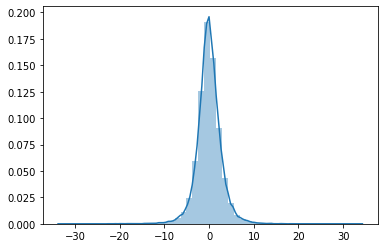

In [11]:
sns.distplot(all_differences)

In [12]:
print(f'mean: {np.mean(all_differences)}, std: {np.std(all_differences)}')

mean: -0.033162071447285946, std: 2.779171625597911


We do not need to run a normality test to see this is normally distributed, but let's run it anyway

In [13]:
st.normaltest(all_differences)

NormaltestResult(statistic=6429.321357675435, pvalue=0.0)

In [14]:
all_fold_changes = foldC.values.flatten()

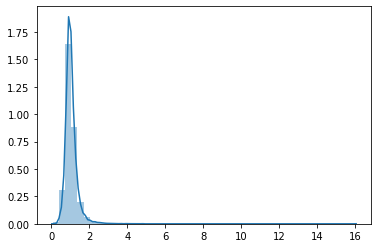

In [15]:
sns.distplot(all_fold_changes)

In [16]:
print(f'mean: {np.mean(all_fold_changes)}, std: {np.std(all_fold_changes)}')

mean: 1.045400504911533, std: 0.3551419115146921


In [17]:
st.normaltest(all_fold_changes)

NormaltestResult(statistic=45889.1532658347, pvalue=0.0)

Let's assume that differences between any two time points are independently drawn from a normal distribution with mean 0 and standard deviation 2.77917...

For any difference we can calculate the probability of observing a difference at least as extreme.

**(This should actually be replaced with fold changes. To be done shortly)**

In [18]:
z_scores_diffs = (diffs)/np.std(all_differences)
p_values_diffs = z_scores_diffs.apply(lambda x: 2*(1 - st.norm.cdf(abs(x))))

In [19]:
z_scores_foldC = (foldC - 1)/np.std(all_fold_changes)
p_values_foldC = z_scores_foldC.apply(lambda x: 2*(1 - st.norm.cdf(abs(x))))

In [20]:
p_values_diffs - p_values_foldC

,10min-0min,60min-0min,2hr-0min,6hr-0min,60min-10min,2hr-10min,6hr-10min,2hr-60min,6hr-60min,6hr-2hr
0,-0.027558,-0.085736,-0.023239,-0.047679,-0.052377,-0.002944,-0.014549,-0.212276,-0.207492,-0.018961
1,-0.011131,-0.088469,-0.076551,-0.040415,-0.076037,-0.080886,-0.028237,-0.062144,-0.027586,-0.140909
2,-0.189059,-0.184337,-0.181540,-0.188037,-0.217458,-0.150612,-0.204862,-0.039609,-0.007940,0.010160
3,-0.014450,-0.169314,-0.166426,-0.175349,-0.158878,-0.155539,-0.166205,-0.003306,-0.009194,-0.013559
4,-0.085571,-0.248180,-0.235237,-0.243647,0.085976,0.054131,0.067650,-0.038757,-0.021323,-0.022755
5,-0.062711,-0.070612,-0.069429,-0.026466,0.029414,0.031729,0.034138,-0.016747,-0.193900,-0.186548
6,-0.064926,-0.046191,-0.029614,-0.020618,-0.066955,-0.103309,-0.118582,-0.034662,-0.050696,-0.014303
7,-0.000353,-0.015676,-0.013934,-0.015143,-0.017794,-0.015685,-0.017136,-0.041579,-0.017301,-0.020582
8,-0.175229,-0.175318,-0.011126,-0.103458,-0.179573,-0.294646,-0.277924,-0.005731,-0.005486,-0.091997
9,-0.181610,-0.033021,-0.139777,-0.183260,0.014254,0.021209,0.000899,-0.169502,-0.188125,-0.116352


We can observe the number of examples with "p_value" less than 0.05

In [21]:
(p_values_diffs < 0.05).sum()

10min-0min     243
60min-0min     301
2hr-0min       128
6hr-0min        79
60min-10min    334
2hr-10min      267
6hr-10min      292
2hr-60min       66
6hr-60min      232
6hr-2hr         35
dtype: int64

In [22]:
(p_values_foldC < 0.05).sum()

10min-0min     175
60min-0min     270
2hr-0min       147
6hr-0min        84
60min-10min    267
2hr-10min      194
6hr-10min      176
2hr-60min       12
6hr-60min       69
6hr-2hr         18
dtype: int64

This p-values must be corrected for multiple comparisons. Let's use Benjamini Hochberg. First let's filter to only columns of interest.

In [23]:
p_relevant_diffs = p_values_diffs.iloc[:, [0, 1, 2, 3, 4, 7, 9]]
p_flat_diffs = p_relevant_diffs.values.flatten()
p_relevant_foldC = p_values_foldC.iloc[:, [0, 1, 2, 3, 4, 7, 9]]
p_flat_foldC = p_relevant_foldC.values.flatten()

In [24]:
p_adjusted_diffs = multipletests(p_flat_diffs, method='fdr_bh')[1]
p_adjusted_foldC = multipletests(p_flat_foldC, method='fdr_bh')[1]

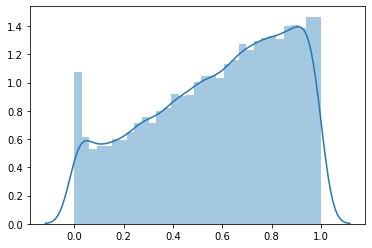

In [25]:
sns.distplot(p_flat_diffs)

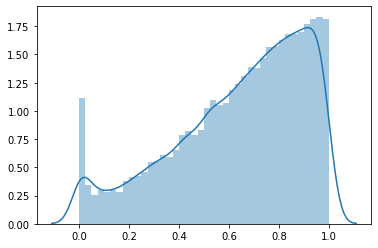

In [26]:
sns.distplot(p_flat_foldC)

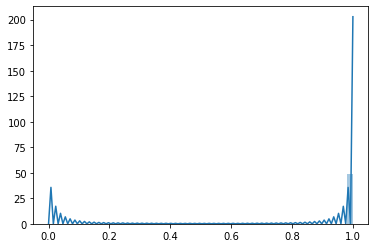

In [27]:
sns.distplot(p_adjusted_diffs)

In [28]:
len([x for x in p_adjusted_foldC if x < 0.2])

456

In [29]:
len([x for x in p_adjusted_diffs if x < 0.2])

289

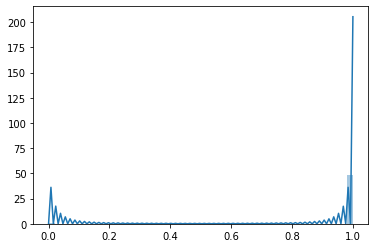

In [30]:
sns.distplot(p_adjusted_foldC)

In [31]:
p_sorted = sorted(p_flat_foldC)
q_sorted = sorted(p_adjusted_foldC)

def q_map(x):
    index = np.searchsorted(p_sorted, x)
    if p_sorted[index] == x:
        return q_sorted[index]
    else:
        return (q_sorted[max(index - 1, 0)] + q_sorted[min(index + 1, len(q_sorted)-1)])/2

In [32]:
q_values_foldC = p_relevant_foldC.applymap(lambda x: q_map(x))

In [35]:
q_values_foldC['peptide'] = q_values_foldC.index.map(lambda x: 'P' + str(x))

In [36]:
q_values_foldC

,10min-0min,60min-0min,2hr-0min,6hr-0min,60min-10min,2hr-60min,6hr-2hr,peptide
0,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P0
1,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P1
2,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P2
3,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P3
4,0.999923,0.999923,0.999923,0.999923,0.626913,0.999923,0.999923,P4
5,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P5
6,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P6
7,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P7
8,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P8
9,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,0.999923,P9


In [42]:
p_first = q_values_foldC.iloc[:, [-1, 0, 1, 2, 3]].copy()
p_prev = q_values_foldC.iloc[:, [-1, 0, 4, 5, 6]].copy()

In [43]:
p_first.to_csv('../work/EpoB_p_values_first.tsv', sep='\t', header=False, index=False)
p_prev.to_csv('../work/EpoB_p_values_prev.tsv', sep='\t', header=False, index=False)

Lets look at the data from the TPS paper and see how many significant differences they found

In [58]:
egf_p_values_prev = pd.read_csv('~/tps/data/timeseries/p-values-prev.tsv', sep='\t')
egf_p_values_first = pd.read_csv('~/tps/data/timeseries/p-values-first.tsv', sep='\t')

In [64]:
egf_p_values_prev.shape

(1068, 8)

In [66]:
p_prev.shape

(3820, 5)

In [67]:
1068*7

7476

In [69]:
3820 * 4

15280

Their data contained measurements from 1068 peptides at 8 timepoints, whereas ours contains measurements from 3820 peptides at 5 timepoints.

They chose a p cutoff of 0.01, they did not adjust these p-values for multicomparison, but did calculate that this cutoff gave a FDR of 0.181 which is close to our chosen value of 0.2

### Number of significant differences in EGF data between first and later timepoints

In [59]:
(egf_p_values_first.iloc[:, 1:] < 0.01).sum()

2min.vs.0min       99
4min.vs.0min      131
8min.vs.0min       95
16min.vs.0min      80
32min.vs.0min      54
64min.vs.0min      42
128min.vs.0min     50
dtype: int64

### Number of significant differences in Yuyu's EpoB data between first and later timepoints

In [60]:
(p_first.iloc[:, 1:] < 0.2).sum()

10min-0min     91
60min-0min    127
2hr-0min       77
6hr-0min       36
dtype: int64

### Number of significant differences in EGF data between successive timepoints

In [63]:
(egf_p_values_prev.iloc[:, 1:] < 0.01).sum()

2min.vs.0min       99
4min.vs.2min       58
8min.vs.4min       35
16min.vs.8min       6
32min.vs.16min      4
64min.vs.32min      5
128min.vs.64min     5
dtype: int64

### Number of significant differences in Yuyu's EpoB data between successive timepoints

In [62]:
(p_prev.iloc[:, 1:] < 0.2).sum()

10min-0min      91
60min-10min    114
2hr-60min        5
6hr-2hr          6
dtype: int64

We see comparable numbers of significant differences found, though we have roughly double the number of differences to test. These numbers are reasonable since their study includes multiple biological replicates while Yuyu's does not (as far as I'm aware)

## Peptide Mapping

TPS asks for a mapping between peptides and the proteins they live inside. These are used in the output to aid in the interpretation of results. Timeseries and p-value files have rows corresponding to peptides. The peptide ID's they use are based on the sequences, but have numbers that I do not yet understand. The sequences in Yuyu's data are not unique, but this may be in error. Let's investigate

There is a column in Yuyu's data called `Site Position` that gives the site position of the phosphorylation in the given protein. Some peptides have multiple sites. In `sequence`, the `#` character is used to denote sites. The number of sites referred to in `Site Position` should match the number of `#`s in `sequence`. Let's check

In [38]:
df['num_sharps'] = df['sequence'].apply(lambda x: x.count('#'))
df['num_site_positions'] = df['Site Position'].apply(lambda x: len(str(x).split(';')))

In [39]:
suspicious = (df['num_sharps'] != df['num_site_positions'])

In [40]:
suspicious.sum()

108

There are 108 examples where this is not the case.

In [46]:
df[suspicious][['Site Position', 'sequence']]

,Site Position,sequence
19,620,K.VGSLT#PPSS#PK.T
23,108,K.LSVPT#S#DEEDEVPAPK.P
24,109,K.LSVPT#S#DEEDEVPAPK.P
82,681,K.IEEVLSPEGS#PSKS#PSK.K
84,677,K.IEEVLS#PEGS#PSK.S
130,5752,K.AS#LGS#LEGEAEAEASSPK.G
166,112,R.AATAARPPAPPPAPQPPS#PTPS#PPRPTLAR.E
271,193,K.S#PPLS#PVGTTPVK.L
283,1203,R.IEDS#EPHIPLIDDT#DAEDDAPTK.R
337,1003,R.AS#PEPQRENAS#PAPGTTAEEAM*SR.G


There's definitely some discrepency here. This can be reevaulated later

Let's just use the dummy peptide mappings based on index. As before, we need to map Uniprot ID's to HGNC symbols